<a href="https://colab.research.google.com/github/RoyaSains/FloodDetection/blob/main/Riya%26Shuya_DeepLearning_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MUSA 650 Final Assignment Proposal: Remote Sensing Solution for Urban Planning**

## **Flood Mapping for Urban Disruptions and Emergency Response**

Shuya Guan and Riya Saini


## **Objectives**
As the frequency and severity of extreme weather events escalate due to climate change, urban transportation infrastructure—including highways, rail systems, and bridges—faces increasing exposure to flood-related disruptions. Recent analyses reveal that the global population residing in flood-prone areas has increased by 20% to 24% since the year 2000, a rate significantly higher than previously projected, with climate-related drivers such as intensified rainfall and sea-level rise cited as major contributors (Environmental Defense Fund, n.d.).
Despite growing awareness, existing flood risk assessments often lack the spatial resolution and predictive capability required by transportation planners to effectively prioritize adaptation strategies. This study proposes the use of machine learning techniques to classify satellite imagery into flooded and non-flooded categories. The principal objective is to enhance flood detection accuracy using Sentinel satellite data, thereby supporting timely disaster response and advancing climate-resilient transportation planning.

<br>

## **Problem Scope**
This research aims to identify flood-prone areas and facilitate a more targeted approach to risk mitigation. Our analysis that can be overlaid with critical transportation corridors, to highlight infrastructure segments that are most at risk. These insights can be used to inform decisions on infrastructure investment, emergency detour planning, and long-term design adaptations to climate hazards.
The urgency of this work is underscored by recent hydrological models projecting a global increase in flooding of 9% to 49% by the end of the 21st century under various climate scenarios (Fathom, 2024). Additionally, compounding factors such as rapid urbanization, outdated drainage systems, and land subsidence are contributing to more frequent and severe flood events (CAF America, 2024). These dynamics necessitate the development of data-driven decision support systems to augment traditional flood management frameworks.

<br>

## **Target Users**
The outputs of this project are intended to serve a range of stakeholders engaged in urban infrastructure and emergency management, particularly those focused on the transportation sector. Key user groups include:
Urban and Regional Planners with a focus in integrating flood vulnerablity into long-range infrastructure planning and zoning decisions.
Public Transit Agencies with a need for real-time operational decisions such as route suspensions or diversions during flood events.
Civil and Transportation Engineers who incorporate flood risk parameters into the design and retrofitting of transportation infrastructure.
By equipping these actors with a predictive tools for rapid flood detection, the study aims to improve the resilience and adaptability of transportation systems in the face of intensifying climate risks.

# 1. Dataset Exploration

**1.1 Data Source Introduction:**

The dataset used in this study is the SEN12-FLOOD datase (available through its DOI: 10.21227/w6xz-s898.), which consists of 336 time series collected from regions affected by major flooding events during the winter of 2019. Each time series includes both Sentinel-1 (SAR grayscale) and Sentinel-2 (RGB optical) satellite images, covering flooded and non-flooded scenes. The dataset is particularly valuable for flood detection tasks because it provides multi-modal imagery with both active and passive sensing data.

The spatial coverage includes areas clustered in East Africa, South West Africa, the Middle East, and Australia, representing diverse geographic and climatic conditions. In total, the dataset contains over 28,000 labeled images, with 17,961 flooded and 10,333 non-flooded samples. Additionally, Sentinel-2 accounts for a larger portion of the data folders compared to Sentinel-1, providing a richer set of RGB imagery suitable for deep learning models.

This combination of multi-source satellite imagery and clear flood labels makes SEN12-FLOOD a robust benchmark for training and evaluating flood classification models.



In [ ]:
# Essential imports for data exploration
import os
import glob
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
!pip install rasterio
import rasterio
from torchvision import transforms
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

# Define dataset directory
data_dir = "/content/drive/MyDrive/Final_Deep Learning/SEN12FLOOD"

In [ ]:
# List all TIFF files recursively
tif_files = glob.glob(os.path.join(data_dir, "**/*.tif"), recursive=True)
print(f"Total TIFF files found: {len(tif_files)}")

# Print sample file paths
print("Sample file paths:")
for f in tif_files[:5]:
    print(f)

s1_files = [f for f in tif_files if "S1" in f]
s2_files = [f for f in tif_files if "S2" in f]
print(f"Sentinel-1 (S1) images : {len(s1_files)}")
print(f"Sentinel-2 (S2) images : {len(s2_files)}")

Total TIFF files found: 28300
Sample file paths:
/content/drive/MyDrive/Final_Deep Learning/SEN12FLOOD/new.tif
/content/drive/MyDrive/Final_Deep Learning/SEN12FLOOD/0005/S1A_IW_GRDH_1SDV_20181216T172604_20181216T172629_025053_02C3AD_6EEA_corrected_VH.tif
/content/drive/MyDrive/Final_Deep Learning/SEN12FLOOD/0005/S1A_IW_GRDH_1SDV_20181221T173347_20181221T173412_025126_02C648_A3BD_corrected_VH.tif
/content/drive/MyDrive/Final_Deep Learning/SEN12FLOOD/0005/S1A_IW_GRDH_1SDV_20181221T173347_20181221T173412_025126_02C648_A3BD_corrected_VV.tif
/content/drive/MyDrive/Final_Deep Learning/SEN12FLOOD/0005/S1A_IW_GRDH_1SDV_20181221T173412_20181221T173437_025126_02C648_B354_corrected_VV.tif
Sentinel-1 (S1) images : 4324
Sentinel-2 (S2) images : 23975


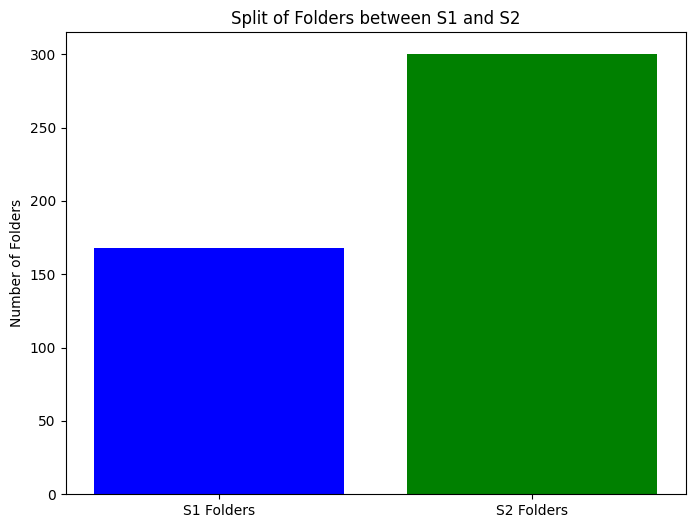

In [ ]:
# Count the number of S1 and S2 folders
s1_folder_count = len(set(os.path.dirname(f) for f in s1_files))
s2_folder_count = len(set(os.path.dirname(f) for f in s2_files))

# Create a bar plot
plt.figure(figsize=(8, 6))
plt.bar(["S1 Folders", "S2 Folders"], [s1_folder_count, s2_folder_count], color=['blue', 'green'])
plt.title("Split of Folders between S1 and S2")
plt.ylabel("Number of Folders")
plt.show()

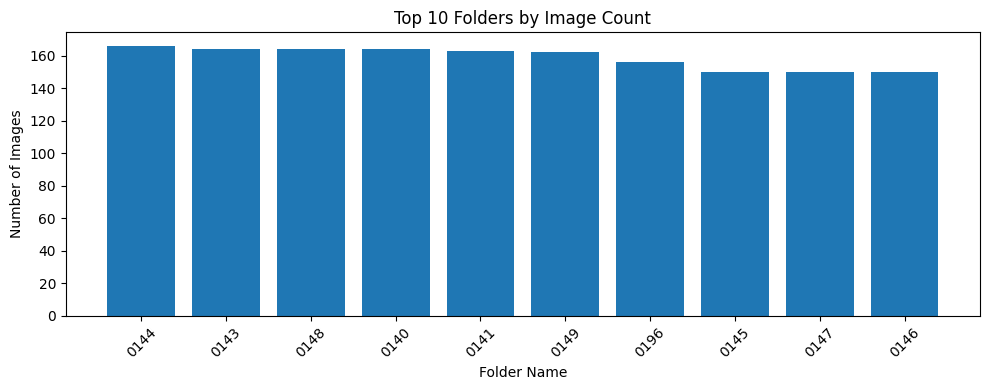

In [ ]:
# Plot distribution of folders
folder_names = [os.path.basename(os.path.dirname(file)) for file in tif_files]
folder_counts = Counter(folder_names)
df_folder_counts = pd.DataFrame(list(folder_counts.items()), columns=["Folder", "Count"])
df_folder_counts = df_folder_counts.sort_values("Count", ascending=False).head(10)

plt.figure(figsize=(10, 4))
plt.bar(df_folder_counts["Folder"], df_folder_counts["Count"])
plt.title("Top 10 Folders by Image Count")
plt.xlabel("Folder Name")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Load metadata JSON files
s1_json_path = os.path.join(data_dir, "S1list.json")
s2_json_path = os.path.join(data_dir, "S2list.json")

flood_labels = {}
# Load Sentinel-1 metadata
if os.path.exists(s1_json_path):
    with open(s1_json_path, "r") as f:
        s1_data = json.load(f)

    # Extract flood labels
    for folder, details in s1_data.items():
        flood_status = any(
            entry.get("FLOODING", False)
            for key, entry in details.items()
            if isinstance(entry, dict) and "FLOODING" in entry
        )
        flood_labels[folder] = int(flood_status)

# Load Sentinel-2 metadata
if os.path.exists(s2_json_path):
    with open(s2_json_path, "r") as f:
        s2_data = json.load(f)

    # Update flood labels
    for folder, details in s2_data.items():
        flood_status = any(
            entry.get("FLOODING", False)
            for key, entry in details.items()
            if isinstance(entry, dict) and "FLOODING" in entry
        )
        flood_labels[folder] = int(flood_status)

Flood Label Mapping (Sample):
Folder: 0063, Flooding: 0
Folder: 0200, Flooding: 1
Folder: 0004, Flooding: 0
Folder: 0307, Flooding: 1
Folder: 0167, Flooding: 1
Folder: 0205, Flooding: 1
Folder: 0166, Flooding: 1
Folder: 0240, Flooding: 1
Folder: 0123, Flooding: 0
Folder: 61, Flooding: 1
Flooded images: 17967
Non-flooded images: 10333
Number of flooded images: 17967
Number of non-flooded images: 10333


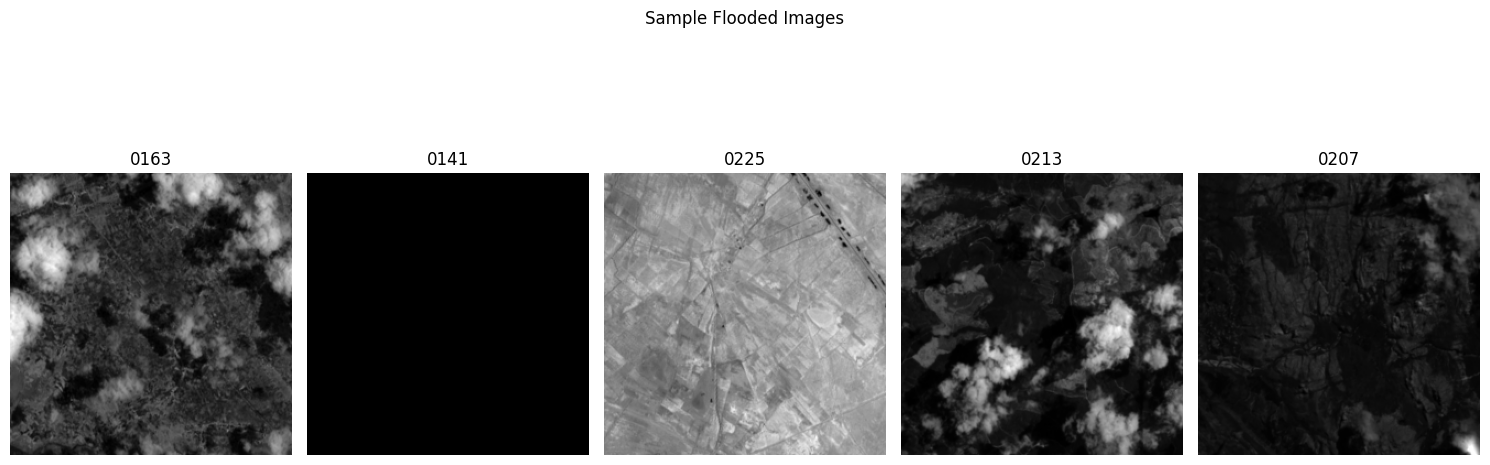

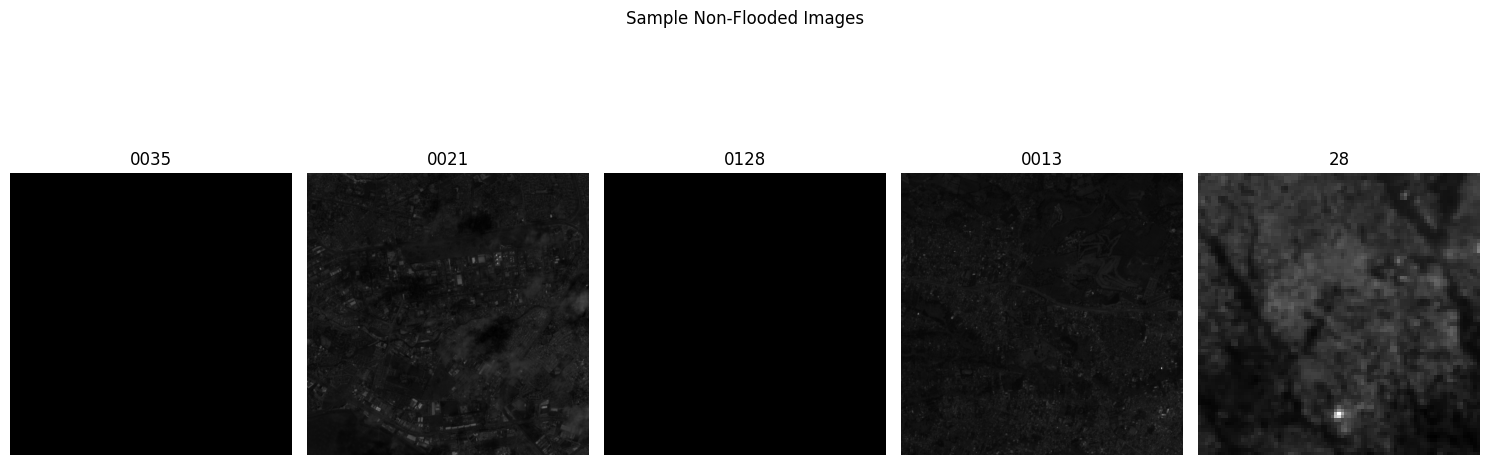

In [ ]:
# Display sample of flood labels
print("Flood Label Mapping (Sample):")
for folder, label in list(flood_labels.items())[:10]:
    print(f"Folder: {folder}, Flooding: {label}")

# Get label distribution
dataset_folder_names = [os.path.basename(os.path.dirname(file)) for file in tif_files]
mapped_labels = [flood_labels.get(folder, 0) for folder in dataset_folder_names]
label_counts = Counter(mapped_labels)
print(f"Flooded images: {label_counts[1]}")
print(f"Non-flooded images: {label_counts[0]}")

# Function to load and process images
def load_raw_greyscale_image(image_filepath):
    try:
        with rasterio.open(image_filepath) as src:
            image_data = src.read(1).astype(float)

        # Contrast stretching
        pixel_min = np.nanmin(image_data)
        pixel_max = np.nanmax(image_data)

        if pixel_max > pixel_min:
            stretched_image = (image_data - pixel_min) / (pixel_max - pixel_min)
        else:
            stretched_image = np.zeros_like(image_data)

        # Convert to 8-bit
        greyscale_image = (stretched_image * 255).clip(0, 255).astype(np.uint8)
        return greyscale_image
    except Exception as e:
        print(f"Error loading {image_filepath}: {e}")
        return np.zeros((256, 256), dtype=np.uint8)  # Return empty image on error

# Split files by label
flooded_files = [f for f in tif_files if flood_labels.get(os.path.basename(os.path.dirname(f)), 0) == 1]
non_flooded_files = [f for f in tif_files if flood_labels.get(os.path.basename(os.path.dirname(f)), 0) == 0]

print("Number of flooded images:", len(flooded_files))
print("Number of non-flooded images:", len(non_flooded_files))

# Display sample images
def display_sample_images(image_files, title, num_samples=5):
    # Randomly sample images if we have more than needed
    if len(image_files) > num_samples:
        sample_files = random.sample(image_files, num_samples)
    else:
        sample_files = image_files

    plt.figure(figsize=(15, 6))
    for idx, image_path in enumerate(sample_files):
        greyscale_img = load_raw_greyscale_image(image_path)
        plt.subplot(1, num_samples, idx+1)
        plt.imshow(greyscale_img, cmap="gray")
        plt.title(os.path.basename(os.path.dirname(image_path)))
        plt.axis("off")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Display sample images
display_sample_images(flooded_files, "Sample Flooded Images")
display_sample_images(non_flooded_files, "Sample Non-Flooded Images")

**1.2 Dataset Description**

This study uses the SEN12-FLOOD dataset, a multi-source satellite image collection designed for flood detection tasks. The dataset comprises 336 time series of both Sentinel-1 (SAR grayscale) and Sentinel-2 (RGB optical) images, covering regions affected by major flooding events during the winter of 2019. These time series are organized in numbered folders (e.g., 0005, 0063) and contain labeled instances of flooded and non-flooded areas, based on binary labels extracted from metadata (where 1 indicates flooded and 0 indicates non-flooded).

A script-based scan of the dataset directory confirmed the presence of 28,300 TIFF images, including Sentinel-1 radar data with VV and VH polarizations, as well as Sentinel-2 optical imagery. According to the label distribution, the dataset includes 17,967 flooded images (approximately 63%) and 10,333 non-flooded images (approximately 37%), offering a reasonably balanced and well-labeled resource for supervised learning.

Visual inspection of sample images shows that flooded areas typically exhibit more defined water patterns and distinct textures, while non-flooded areas present more stable land features. Some Sentinel-1 images appear very dark and may require preprocessing to enhance signal quality and texture visibility, especially when used in combination with optical data.


**1.3 Sentinel-2 Selection for CNN Modeling**

Given the task’s reliance on RGB imagery for deep learning, particularly convolutional neural networks (CNNs), we focus on using Sentinel-2 data for model development. This decision is supported by several factors:

RGB Composition: Sentinel-2 provides bands B04 (red), B03 (green), and B02 (blue), which together form true-color RGB images ideal for training CNN-based image classification or segmentation models.

Spatial Resolution: The RGB bands of Sentinel-2 have a 10-meter pixel resolution, providing clearer visual information than Sentinel-1 grayscale radar images. This allows better distinction of features like roads, water boundaries, and vegetation textures.

Data Quantity: The dataset contains over 24,000 Sentinel-2 images, offering a large and diverse input space that supports robust model training and evaluation.

In contrast, Sentinel-1 provides only single-channel grayscale data (VV and VH), which lacks the spectral and color richness needed for CNNs that depend on RGB input. For this reason, Sentinel-2 is prioritized for vision-based modeling in this study.

In [ ]:
#Optional: For Sentinel-1 radar (SAR) data
def show_sar_bands(image_path):
    with rasterio.open(image_path) as src:
        img = src.read(1)
    plt.imshow(img, cmap="gray")
    plt.title("SAR (VV or VH)")
    plt.axis("off")
    plt.show()

#Or both VV and VH, do a false-color:
def show_sar_rgb(vv_path, vh_path):
    with rasterio.open(vv_path) as src1, rasterio.open(vh_path) as src2:
        vv = src1.read(1)
        vh = src2.read(1)
        diff = vv - vh
        img = np.stack([vv, vh, diff], axis=-1)
        img = img.astype(np.uint8)

    plt.imshow(img)
    plt.title("SAR False Color (VV, VH, VV-VH)")
    plt.axis("off")
    plt.show()

# 2. Data Preprocessing Pipeline

In [ ]:
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader

# Config
data_dir = "/content/drive/MyDrive/Final_Deep Learning/SEN12FLOOD"
all_folders = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, f))]
print(f"Found {len(all_folders)} folders.")

# Transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

Found 335 folders.


In [ ]:
def read_rgb_from_folder(folder_path):
    try:
        files = [f for f in os.listdir(folder_path) if f.endswith(".tif") and "B0" in f]

        # Organize by date
        band_dict = {}
        for f in files:
            parts = f.split("_")
            if len(parts) < 3:
                continue  # Skip unexpected filenames
            date = parts[1]
            band = parts[2].replace(".tif", "")
            band_dict.setdefault(date, {})[band] = f

        # Find the first valid date with B02, B03, B04
        for date, bands in band_dict.items():
            if all(b in bands for b in ["B02", "B03", "B04"]):
                r_path = os.path.join(folder_path, bands["B04"])
                g_path = os.path.join(folder_path, bands["B03"])
                b_path = os.path.join(folder_path, bands["B02"])

                r = rasterio.open(r_path).read(1).astype(np.float32)
                g = rasterio.open(g_path).read(1).astype(np.float32)
                b = rasterio.open(b_path).read(1).astype(np.float32)

                # Normalize using percentile stretch
                def normalize_band(band):
                    p2, p98 = np.percentile(band, (2, 98))
                    band = np.clip((band - p2) / (p98 - p2 + 1e-5), 0, 1)
                    return band

                r, g, b = normalize_band(r), normalize_band(g), normalize_band(b)

                rgb = np.stack([r, g, b], axis=-1)
                rgb = (rgb * 255).astype(np.uint8)
                return Image.fromarray(rgb)

        raise RuntimeError("No common date with all 3 bands found.")

    except Exception as e:
        raise RuntimeError(f"Error reading RGB bands in {folder_path}: {e}")

In [ ]:
import os
from collections import defaultdict

def is_valid_folder(folder_path):
    tif_files = [f for f in os.listdir(folder_path) if f.endswith(".tif") and "B0" in f]
    band_dates = defaultdict(set)

    for file in tif_files:
        parts = file.split('_')
        if len(parts) < 3:
            continue
        _, date, band = parts[0], parts[1], parts[2].replace(".tif", "")
        band_dates[date].add(band)

    for date, bands in band_dates.items():
        if {'B02', 'B03', 'B04'}.issubset(bands):
            return True  # Valid: has all 3 bands for one date

    return False  # No date had all 3 bands

In [ ]:
from tqdm import tqdm
folder_paths = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, f))] # Define folder_paths
valid_folders = []
invalid_folders = []

for folder in tqdm(folder_paths):
    if is_valid_folder(folder):
        valid_folders.append(folder)
    else:
        invalid_folders.append(folder)

print(f" Valid folders: {len(valid_folders)} / {len(folder_paths)}")

100%|██████████| 335/335 [00:00<00:00, 508.63it/s]

 Valid folders: 300 / 335


**2.1 Data Preprocessing**

To ensure model reliability and input consistency, we applied a structured preprocessing pipeline focused on clean data selection, RGB band alignment, and subset-specific transformations.

**a.Band Selection and Filtering**
Each sample folder in the SEN12-FLOOD dataset contains multiple Sentinel-2 .tif images, each corresponding to a specific spectral band and acquisition date. To construct valid RGB images, we required the presence of B02 (blue), B03 (green), and B04 (red) bands captured on the same date. This step is critical, as Sentinel-2 captures images on different dates for different bands, and mismatched timestamps can lead to corrupted RGB compositions.

A custom script was implemented to iterate through all 335 folders, identify valid band-date combinations, and retain only those folders where all three required bands were available for at least one shared timestamp. This resulted in 300 valid folders, confirming that ~90% of the dataset is suitable for RGB reconstruction.

**b. Reflectance Scaling and Normalization**
For RGB generation, raw band values were read using rasterio and processed as float32 arrays. To enhance feature contrast while preserving dynamic range, we applied percentile-based normalization: band values were stretched between their 2nd and 98th percentiles, clipped, and scaled to [0, 1] before being converted to 8-bit RGB images. This method helps minimize the impact of outliers while maintaining visual clarity. Alternatives such as dividing by a constant (e.g., 10,000 for reflectance scaling) were considered, following ESA recommendations, but percentile scaling offered better empirical contrast.

**c. Cloud Filtering**
During manual review, several images were found to be dominated by heavy cloud coverage or dark/noisy regions. These cases were implicitly filtered out by the valid-folder check, since folders lacking usable RGB bands on the same date were excluded. While more advanced cloud detection could be added, this simple filter was effective in improving overall quality.

**d. Dataset Splitting**
After filtering, the 300 valid folders were split by folder into training (70%, 210 folders), validation (15%, 45 folders), and test (15%, 45 folders) sets. This folder-level splitting ensures no spatial or temporal leakage between subsets.

**e. Transformations**
To preserve data integrity and allow subset-specific handling, transformations were applied after splitting:

*Training set:* images were resized to 224×224, then augmented with random horizontal flips and small-angle rotations to increase robustness. Normalization to a range of [–1, 1] was also applied via (x – 0.5) / 0.5.

*Validation and test sets:* only resizing and normalization were applied, keeping them clean for unbiased evaluation.

We aim to use this approach allowing the training process to benefit from diversity and regularization via augmentation, while ensuring that validation and test sets accurately reflect real-world input distributions.



In [ ]:
# Shuffle and split ONLY valid folders
random.shuffle(valid_folders)
train_size = int(0.7 * len(valid_folders))
val_size = int(0.15 * len(valid_folders))
test_size = len(valid_folders) - train_size - val_size

train_folders = valid_folders[:train_size]
val_folders = valid_folders[train_size:train_size + val_size]
test_folders = valid_folders[train_size + val_size:]

In [ ]:
# Dataset
class Sentinel2RGBDataset(Dataset):
    def __init__(self, folder_paths, label_map, transform=None):
        self.folder_paths = folder_paths
        self.label_map = label_map
        self.transform = transform

    def __len__(self):
        return len(self.folder_paths)

    def __getitem__(self, idx):
        tries = 0
        while tries < 5:
            folder = self.folder_paths[idx]
            folder_name = os.path.basename(folder)
            label = self.label_map.get(folder_name, 0)
            try:
                image = read_rgb_from_folder(folder)
                if self.transform:
                    image = self.transform(image)
                return image, label
            except Exception as e:
                print(f"Skipping folder {folder}: {e}")
                idx = (idx + 1) % len(self.folder_paths)
                tries += 1
        return torch.zeros((3, 224, 224)), 0  # fallback


# Datasets & Loaders
train_dataset = Sentinel2RGBDataset(train_folders, flood_labels, transform=train_transform)
val_dataset = Sentinel2RGBDataset(val_folders, flood_labels, transform=val_test_transform)
test_dataset = Sentinel2RGBDataset(test_folders, flood_labels, transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Check a sample
images, labels = next(iter(train_loader))
print(f"Sample batch shape: {images.shape}, labels: {labels[:5]}")

Sample batch shape: torch.Size([32, 3, 224, 224]), labels: tensor([1, 0, 0, 1, 0])


In [ ]:
print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

Train: 210, Val: 45, Test: 45


**2.2 Dataset Construction and Splitting Strategy**

In this project, each folder in the SEN12-FLOOD dataset is treated as one scene—meaning a specific location at a specific time. A valid scene contains three Sentinel-2 bands (B02, B03, and B04) from the same date, which we use to form an RGB image. Each folder also comes with a binary label: 1 for flooded, 0 for non-flooded.

To avoid data leakage, we split the dataset by folder rather than by image. This is important because nearby or repeated scenes can look very similar. Random image-level splitting could put almost identical samples in both training and test sets, leading to misleading results. We followed best practice by shuffling all 300 valid folders and splitting them into 70% for training (210 folders), 15% for validation (45), and 15% for testing (45), making sure each set contains distinct scenes.

We used a custom PyTorch Dataset class to load RGB images and labels. For training, we applied resizing, normalization, and light augmentation (random flip and rotation). For validation and testing, we only used resizing and normalization to keep evaluation consistent.

If a folder fails to load properly, the dataset class skips it and tries a nearby one. This makes the dataloader more stable. Each sample becomes a 3-channel tensor of shape [3, 224, 224], with a binary label. A sample batch confirmed that the pipeline runs as expected.

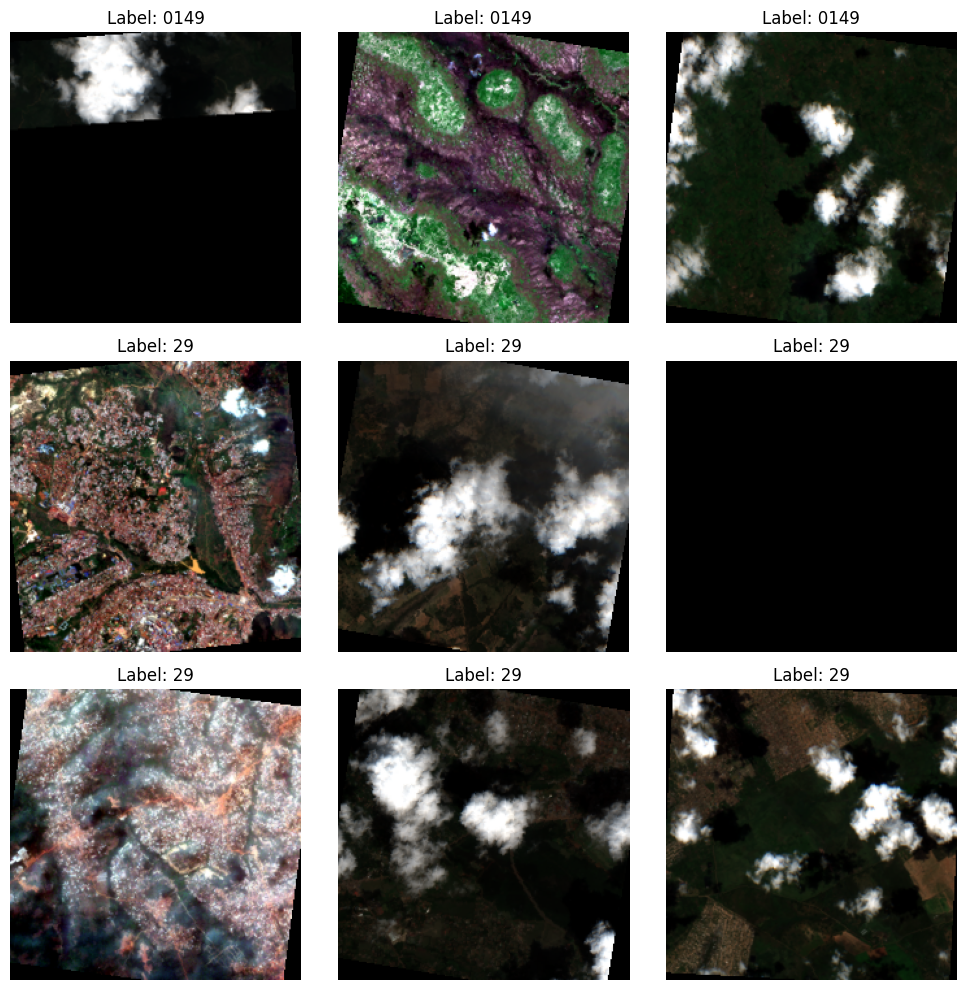

In [ ]:
# Helper to unnormalize the image for display
def unnormalize(tensor):
    """Convert normalized image tensor back to [0, 1] for display"""
    tensor = tensor * 0.5 + 0.5  # Assuming normalization mean=0.5, std=0.5
    return tensor

# Define class label names for visualization
label_names = {v: k for k, v in flood_labels.items()}  # e.g., {0: 'nonflooded', 1: 'flooded'}

# Plot a few images from the training dataset
def plot_samples(dataset, num_samples=9):
    plt.figure(figsize=(10, 10))
    for i in range(num_samples):
        image, label = dataset[i]
        image = unnormalize(image)  # Undo normalization
        image_np = image.permute(1, 2, 0).numpy()  # Convert to HWC format for plotting

        plt.subplot(3, 3, i + 1)
        plt.imshow(image_np)
        plt.title(f"Label: {label_names.get(label, label)}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Show samples
plot_samples(train_dataset)

# 3. Model Development

Before building our own model, we looked at two existing approaches that are commonly used for flood detection: UN-SPIDER and WorldFloods. They take very different approaches and help highlight the trade-offs involved in flood mapping with satellite data.

*UN-SPIDER*, developed by the United Nations, is a rule-based method that relies on comparing pre- and post-event Sentinel-1 SAR images. It uses simple thresholds—typically based on changes in backscatter values—to detect flooded areas. Sometimes, it includes additional layers like elevation or land cover, or uses basic classifiers like random forests if training data is available. The main advantage is that it’s lightweight and easy to run, even with limited computing resources. But the downside is its low accuracy and inability to capture complex features, especially in urban areas.

*WorldFloods*, developed by Oxford and the Frontier Development Lab, uses a U-Net deep learning model trained on multi-temporal Sentinel-1 SAR inputs. It produces pixel-wise flood maps and performs well, even under cloud cover. However, it requires multi-source inputs, including several SAR bands and often elevation data. This makes it harder to set up and less flexible in situations where only RGB or limited data is available.

These two models show a clear trade-off: one is simple but limited, the other is powerful but complex. Our goal is to explore a middle ground—using only RGB images from Sentinel-2 to build a model that is easier to train and deploy, while still offering reasonable accuracy. This helps lower the barrier to entry and increases the model’s applicability in real-world settings where access to multi-modal data or high-end hardware may be limited.


# 3.1 Random Forest Baseline

In [ ]:
# Step 1: Convert Images to Flattened Numpy Arrays
def loader_to_numpy(dataloader):
    images_list, labels_list = [], []
    for images, labels in tqdm(dataloader):
        imgs_np = images.numpy()  # Convert to numpy
        lbls_np = labels.numpy()
        imgs_np = imgs_np.reshape(imgs_np.shape[0], -1)  # Flatten: (3, 224, 224) → (150528,)
        images_list.append(imgs_np)
        labels_list.append(lbls_np)
    return np.vstack(images_list), np.concatenate(labels_list)

# Extract training and testing data
X_train, y_train = loader_to_numpy(train_loader)
X_val, y_val = loader_to_numpy(val_loader)
X_test, y_test = loader_to_numpy(test_loader)


100%|██████████| 2/2 [01:25<00:00, 42.64s/it]


In [ ]:
# save datasets for use as pytorch tensors. Will need to be converted to numpy arrays for Random Forest. Use as tensors for CNN.
# save as pytorch
torch.save((X_train, y_train), '/content/drive/MyDrive/Final_Deep Learning/train_data.pt')
torch.save((X_val, y_val), '/content/drive/MyDrive/Final_Deep Learning/val_data.pt')
torch.save((X_test, y_test), '/content/drive/MyDrive/Final_Deep Learning/test_data.pt')

# save as numpy arrays
np.savez('/content/drive/MyDrive/Final_Deep Learning/train_data.npz', X=X_train, y=y_train)
np.savez('/content/drive/MyDrive/Final_Deep Learning/val_data.npz', X=X_val, y=y_val)
np.savez('/content/drive/MyDrive/Final_Deep Learning/test_data.npz', X=X_test, y=y_test)

In [ ]:
# load as numpy array to be used for Random Forest model
train_data = np.load('/content/drive/MyDrive/Final_Deep Learning/train_data.npz')
X_train, y_train = train_data['X'], train_data['y']

val_data = np.load('/content/drive/MyDrive/Final_Deep Learning/val_data.npz')
X_val, y_val = val_data['X'], val_data['y']

test_data = np.load('/content/drive/MyDrive/Final_Deep Learning/test_data.npz')
X_test, y_test = test_data['X'], test_data['y']

In [ ]:
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    max_features='sqrt',
    min_samples_leaf=2,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1)

# 5-Fold Stratified Cross-Validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=kfold, scoring='accuracy')

print(f"Cross-Validation Accuracy Scores: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

rf_model.fit(X_train, y_train)

Cross-Validation Accuracy Scores: [0.78571429 0.69047619 0.64285714 0.66666667 0.52380952]
Mean CV Accuracy: 0.6619 ± 0.0844


RandomForestClassifier(class_weight='balanced', max_depth=15,
                       min_samples_leaf=2, n_estimators=200, n_jobs=-1,
                       random_state=42)


Validation Set Evaluation:
Accuracy: 0.6
Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.21      0.31        19
           1       0.61      0.88      0.72        26

    accuracy                           0.60        45
   macro avg       0.59      0.55      0.51        45
weighted avg       0.59      0.60      0.55        45



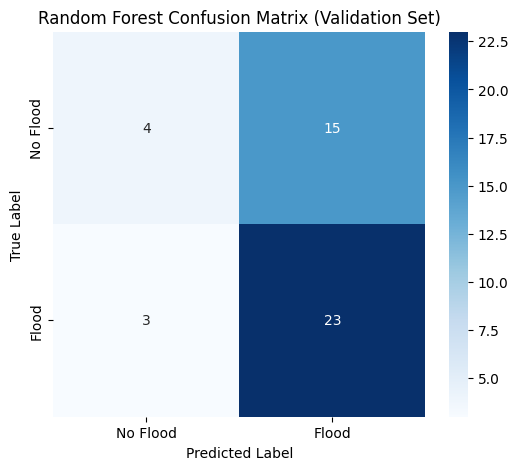

In [ ]:
# Predict on validation set
y_val_pred = rf_model.predict(X_val)

# Performance evaluation
print("\nValidation Set Evaluation:")
print("Accuracy:", accuracy_score(y_val, y_val_pred))
print("Classification Report:\n", classification_report(y_val, y_val_pred))

# Confusion Matrix Plot
conf_matrix_val = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_val, annot=True, fmt='d', cmap="Blues", xticklabels=['No Flood', 'Flood'], yticklabels=['No Flood', 'Flood'])
plt.title("Random Forest Confusion Matrix (Validation Set)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

AUC: 0.7055


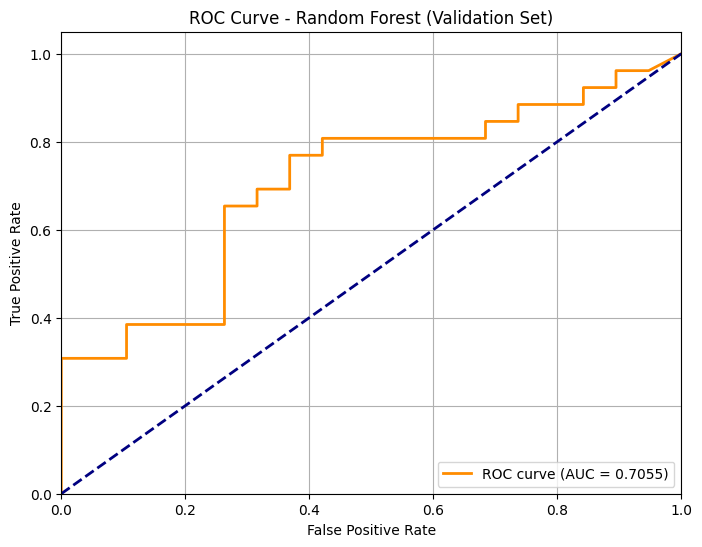

In [ ]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

# Get probability estimates for class 1 ("Flood")
y_val_probs = rf_model.predict_proba(X_val)[:, 1]  # Get probs for class 1
fpr, tpr, thresholds = roc_curve(y_val, y_val_probs)
roc_auc = auc(fpr, tpr)

print(f"AUC: {roc_auc:.4f}")
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest (Validation Set)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


As an initial baseline, we trained a *Random Forest* classifier using flattened Sentinel-2 RGB images. Since *Random Forests* require tabular input, we first converted each 3×224×224 image into a flat vector and stored the entire dataset as NumPy arrays. This process allowed us to feed the data into the model, though it came at the cost of losing spatial structure.

We used 200 estimators, limited the tree depth to 15, and applied class weighting to handle the slight imbalance between flooded and non-flooded samples. Cross-validation on the training set produced an average accuracy of 66.2%, with some variation across folds. On the validation set, we saw an overall accuracy of 60%. While the model performed well at detecting flooded scenes (recall of 0.88), it struggled with non-flooded areas, where recall dropped to 0.21. The confusion matrix clearly showed this skew, with many non-flooded samples being misclassified as flooded.

Still, the ROC curve gave us an AUC of 0.705, suggesting the model was learning a reasonably good separation, even if thresholding was off. These results highlight the limits of traditional models like *Random Forest* when applied to high-dimensional image data. Flattening the images removed spatial relationships, which are often crucial for visual tasks like flood detection. This baseline helped clarify the need for a model that can directly work with image structure—something we address with our CNN-based approach.

# 3.2 CNN-Based Model: ResNet18

In [ ]:
# Use pytorch tensors for CNN
# from torch.utils.data import TensorDataset, DataLoader

# X_train, y_train = torch.load('/content/drive/MyDrive/Final_Deep Learning/train_data.pt', weights_only=False)
# X_val, y_val = torch.load('/content/drive/MyDrive/Final_Deep Learning/val_data.pt', weights_only=False)
# X_test, y_test = torch.load('/content/drive/MyDrive/Final_Deep Learning/test_data.pt', weights_only=False)

In [ ]:
# Convert numpy arrays to PyTorch tensors
from torch.utils.data import TensorDataset, DataLoader
X_train = torch.tensor(X_train, dtype=torch.float32).reshape(-1, 3, 224, 224)
y_train = torch.tensor(y_train, dtype=torch.long)

X_val = torch.tensor(X_val, dtype=torch.float32).reshape(-1, 3, 224, 224)
y_val = torch.tensor(y_val, dtype=torch.long)

X_test = torch.tensor(X_test, dtype=torch.float32).reshape(-1, 3, 224, 224)
y_test = torch.tensor(y_test, dtype=torch.long)

# Step 3: Wrap tensors in datasets
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

# Step 4: Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
import torch.nn as nn
import torchvision.models as models

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pretrained ResNet18
class FloodResNet(nn.Module):
    def __init__(self):
        super(FloodResNet, self).__init__()
        self.base_model = models.resnet18(pretrained=True)

        # Modify final layer for binary classification
        num_features = self.base_model.fc.in_features
        self.base_model.fc = nn.Linear(num_features, 2)  # Binary output

    def forward(self, x):
        return self.base_model(x)

# Instantiate the model and move it to the device
model = FloodResNet().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Since output is 2 logits
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Train_epoch and Validate_epoch for CNN
def train_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


def validate_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

In [ ]:
# Setup
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer_resnet = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 50
patience = 3
best_val_loss = float('inf')
epochs_no_improve = 0

res_train_losses, res_train_accuracies = [], []
res_val_losses, res_val_accuracies = [], []

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, optimizer_resnet, criterion, device)
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)

    res_train_losses.append(train_loss)
    res_train_accuracies.append(train_acc)
    res_val_losses.append(val_loss)
    res_val_accuracies.append(val_acc)

    print(f"\n ResNet - Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping due to no improvement.")
            break



 ResNet - Epoch 1/50
Train Loss: 0.5132 | Train Acc: 0.7524
Val Loss:   0.3923 | Val Acc:   0.8000

 ResNet - Epoch 2/50
Train Loss: 0.1487 | Train Acc: 0.9571
Val Loss:   0.3367 | Val Acc:   0.8222

 ResNet - Epoch 3/50
Train Loss: 0.0854 | Train Acc: 0.9762
Val Loss:   0.2709 | Val Acc:   0.8667

 ResNet - Epoch 4/50
Train Loss: 0.0707 | Train Acc: 0.9714
Val Loss:   0.3018 | Val Acc:   0.8444

 ResNet - Epoch 5/50
Train Loss: 0.0681 | Train Acc: 0.9714
Val Loss:   0.3052 | Val Acc:   0.8667

 ResNet - Epoch 6/50
Train Loss: 0.0554 | Train Acc: 0.9667
Val Loss:   0.3095 | Val Acc:   0.8444
Early stopping due to no improvement.


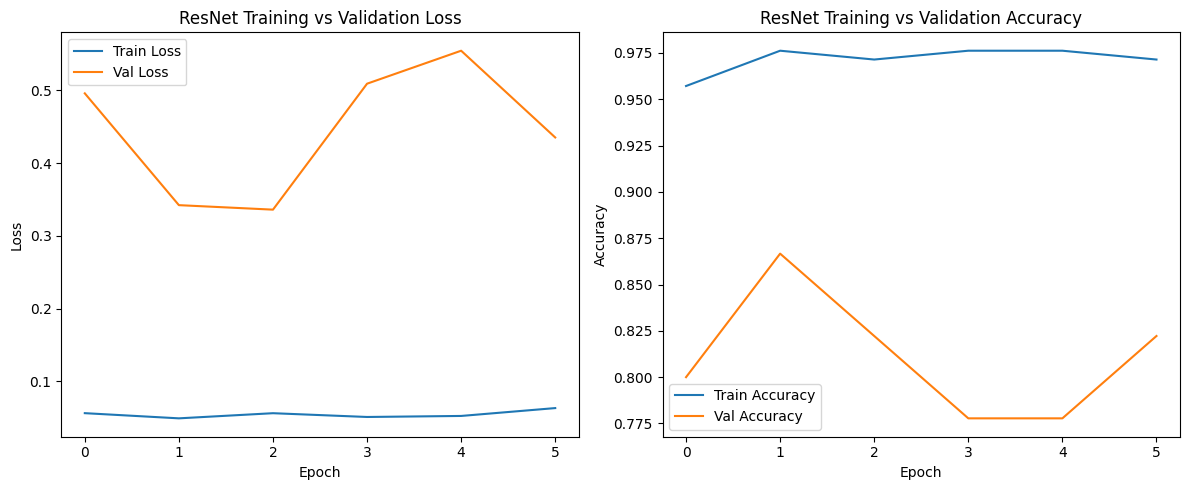

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(res_train_losses, label='Train Loss')
plt.plot(res_val_losses, label='Val Loss')
plt.title('ResNet Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(res_train_accuracies, label='Train Accuracy')
plt.plot(res_val_accuracies, label='Val Accuracy')
plt.title('ResNet Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix, roc_curve, auc
import torch.nn.functional as F

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

acc = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
report = classification_report(all_labels, all_preds, target_names=['No Flood', 'Flood'])

print(f"Accuracy: {acc:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Classification Report:\n", report)

Accuracy: 0.8222
F1 Score: 0.8462
Classification Report:
               precision    recall  f1-score   support

    No Flood       0.79      0.79      0.79        19
       Flood       0.85      0.85      0.85        26

    accuracy                           0.82        45
   macro avg       0.82      0.82      0.82        45
weighted avg       0.82      0.82      0.82        45



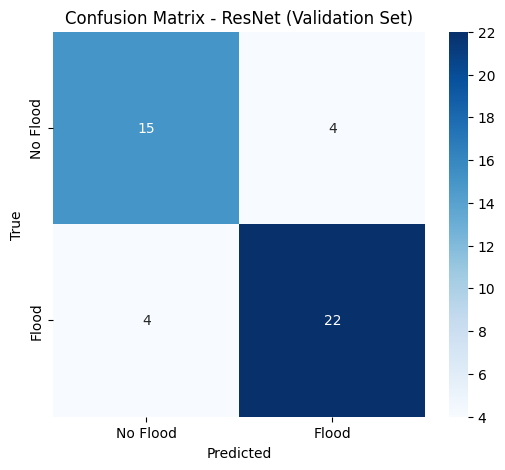

In [ ]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Flood', 'Flood'], yticklabels=['No Flood', 'Flood'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - ResNet (Validation Set)')
plt.show()

AUC: 0.9261


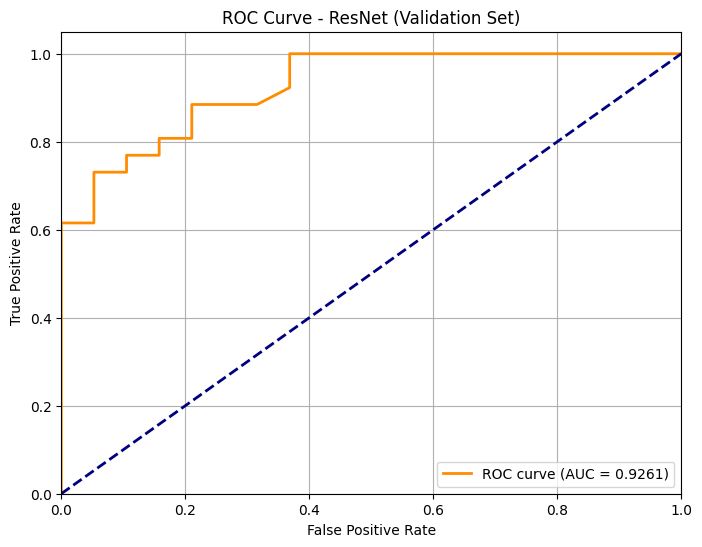

In [ ]:
all_probs = []  # collect probabilities for class 1

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)[:, 1]  # probability for class 1 (Flood)

        all_probs.extend(probs.cpu().numpy())

fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

print(f"AUC: {roc_auc:.4f}")

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - ResNet (Validation Set)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

To take advantage of the spatial structure in satellite images, we trained a convolutional neural network using a ResNet18 backbone. We modified the final fully connected layer for binary classification and used cross-entropy loss with the Adam optimizer. The model was trained on RGB images of shape 3×224×224, and we applied early stopping based on validation loss to avoid overfitting.

From the start, the model showed strong performance on the training set, reaching over 95% accuracy within a few epochs. On the validation set, performance fluctuated more, but eventually stabilized around 82%. Although validation loss did not decrease consistently, the accuracy and ROC curve suggest that the model was learning useful patterns. Our best validation AUC reached 0.926, showing a clear separation between classes.

Looking at the confusion matrix, the model correctly predicted 15 of 19 non-flooded samples and 22 of 26 flooded ones. Precision and recall were balanced across both classes, each around 0.79–0.85, leading to an F1 score of 0.846 overall. Compared to the Random Forest baseline, the ResNet model handled both classes more evenly and achieved a much higher AUC, suggesting that the convolutional architecture was better able to capture local textures and spatial context that are critical in flood detection.

Overall, the ResNet18 model provided a clear improvement in performance, especially in its ability to generalize across classes and to preserve meaningful patterns in the imagery. While the training set was small, the model's results were stable, and the use of RGB alone—without any additional SAR or elevation data—demonstrated strong potential for lightweight flood mapping tasks.



# 3. EfficientNet-B0 Model

In [ ]:
!pip install timm
import timm
import torch.nn as nn
import torch.optim as optim

# Load EfficientNet-B0 with pretrained weights
efficientnet_model = timm.create_model('efficientnet_b0', pretrained=True)

# Modify classifier layer for binary classification
num_features = efficientnet_model.get_classifier().in_features
efficientnet_model.classifier = nn.Linear(num_features, 2)

efficientnet_model = efficientnet_model.to(device)
print("EfficientNet-B0 loaded and ready for binary classification.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 30.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 27.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 61.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

EfficientNet-B0 loaded and ready for binary classification.


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer_eff = optim.AdamW(efficientnet_model.parameters(), lr=1e-4)

num_epochs = 50
patience = 3
early_stop_threshold = 0.001

eff_train_losses, eff_train_accuracies = [], []
eff_val_losses, eff_val_accuracies = [], []

best_val_loss = float('inf')
epochs_no_improve = 0

In [ ]:
# Train_epoch and Validate_epoch for CNN
def train_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


def validate_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

In [ ]:
for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(efficientnet_model, train_loader, optimizer_eff, criterion, device)
    val_loss, val_acc = validate_epoch(efficientnet_model, val_loader, criterion, device)

    eff_train_losses.append(train_loss)
    eff_train_accuracies.append(train_acc)
    eff_val_losses.append(val_loss)
    eff_val_accuracies.append(val_acc)

    print(f"\n Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")

    if val_loss < early_stop_threshold:
        print("Validation loss is negligible — early stopping.")
        break

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"No improvement for {patience} epochs — early stopping.")
            break



 Epoch 1/50
Train Loss: 0.6201 | Train Acc: 0.6952
Val Loss:   0.5646 | Val Acc:   0.7556

 Epoch 2/50
Train Loss: 0.3951 | Train Acc: 0.9286
Val Loss:   0.4592 | Val Acc:   0.8889

 Epoch 3/50
Train Loss: 0.3052 | Train Acc: 0.9333
Val Loss:   0.3808 | Val Acc:   0.8667

 Epoch 4/50
Train Loss: 0.2110 | Train Acc: 0.9619
Val Loss:   0.3106 | Val Acc:   0.8667

 Epoch 5/50
Train Loss: 0.1532 | Train Acc: 0.9619
Val Loss:   0.2725 | Val Acc:   0.8667

 Epoch 6/50
Train Loss: 0.1170 | Train Acc: 0.9762
Val Loss:   0.2517 | Val Acc:   0.8444

 Epoch 7/50
Train Loss: 0.1300 | Train Acc: 0.9667
Val Loss:   0.2387 | Val Acc:   0.8667

 Epoch 8/50
Train Loss: 0.0838 | Train Acc: 0.9762
Val Loss:   0.2342 | Val Acc:   0.8889

 Epoch 9/50
Train Loss: 0.0826 | Train Acc: 0.9619
Val Loss:   0.2265 | Val Acc:   0.8667

 Epoch 10/50
Train Loss: 0.0650 | Train Acc: 0.9762
Val Loss:   0.2088 | Val Acc:   0.8889

 Epoch 11/50
Train Loss: 0.0632 | Train Acc: 0.9762
Val Loss:   0.2038 | Val Acc:   0.88

In [ ]:
efficientnet_model.eval()
all_preds, all_labels, all_probs = [], [], []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = efficientnet_model(images)
        probs = torch.softmax(outputs, dim=1)[:, 1]  # Probability of class 1 (Flood)
        _, preds = torch.max(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())


In [ ]:
acc = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
report = classification_report(all_labels, all_preds, target_names=['No Flood', 'Flood'])

print(f"Accuracy: {acc:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Classification Report:\n", report)


Accuracy: 0.8889
F1 Score: 0.9020
Classification Report:
               precision    recall  f1-score   support

    No Flood       0.85      0.89      0.87        19
       Flood       0.92      0.88      0.90        26

    accuracy                           0.89        45
   macro avg       0.89      0.89      0.89        45
weighted avg       0.89      0.89      0.89        45



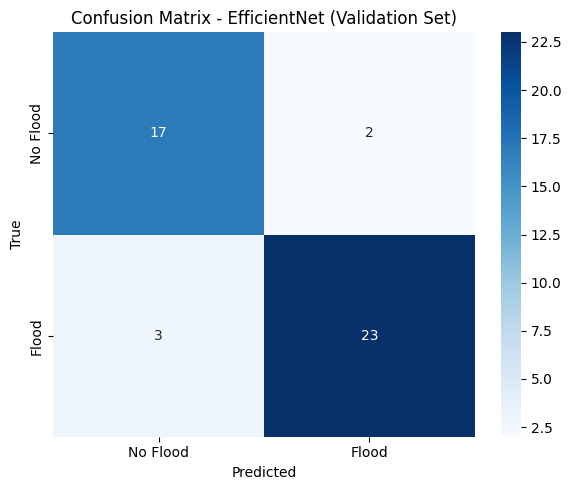

In [ ]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Flood', 'Flood'], yticklabels=['No Flood', 'Flood'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - EfficientNet (Validation Set)')
plt.tight_layout()
plt.show()


AUC: 0.9706


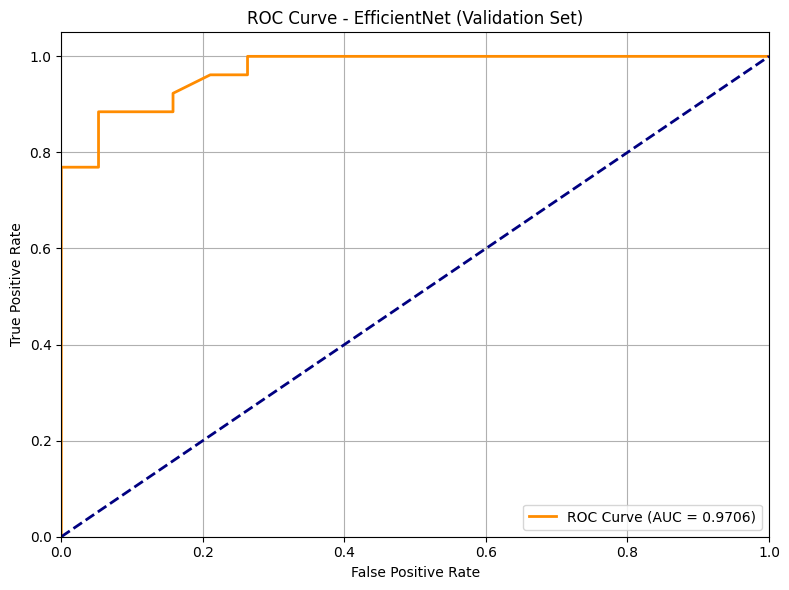

In [ ]:
# roc
fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

print(f"AUC: {roc_auc:.4f}")

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - EfficientNet (Validation Set)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


To further explore the potential of CNNs in RGB-based flood detection, we fine-tuned an EfficientNet-B0 model pre-trained on ImageNet. We replaced the final classification layer with a two-class output and trained the model using AdamW with a learning rate of 1e-4. Early stopping was applied based on validation loss, with a patience of 3 epochs.

Training progressed smoothly, and the model reached high accuracy quickly. After about five epochs, training accuracy stabilized above 97%, and validation accuracy hovered consistently around 88–89%. Compared to the previous ResNet18 model, EfficientNet converged faster and showed slightly more stable validation performance. The validation loss also improved steadily, reaching its minimum near epoch 11.

Performance on the validation set was strong across all metrics. The overall accuracy reached 88.9%, with an F1 score of 0.902. Both classes were handled well: the model correctly identified 17 of 19 non-flooded areas and 23 of 26 flooded areas. Precision and recall were well balanced, as confirmed by the confusion matrix.

The ROC curve further highlighted the model’s discriminative power, with an AUC of 0.9706. This is the highest among all models tested, suggesting that EfficientNet was particularly effective at learning subtle visual patterns from RGB imagery.

Overall, EfficientNet-B0 not only matched but slightly outperformed the ResNet baseline, especially in terms of calibration and class balance. Its lightweight architecture and strong validation results suggest it’s a solid choice for flood detection tasks where both accuracy and efficiency matter.

# 4. Model Comparison

In [ ]:
# Predict on test set with Random Forest
y_test_pred_rf = rf_model.predict(X_test)
y_test_prob_rf = rf_model.predict_proba(X_test)[:, 1]  # For ROC AUC (binary)

In [ ]:
# Predict on test set with ResNet
model.eval()
y_test_pred_resnet = []
y_test_prob_resnet = []
y_test_true = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)[:, 1]
        _, preds = torch.max(outputs, 1)

        y_test_pred_resnet.extend(preds.cpu().numpy())
        y_test_prob_resnet.extend(probs.cpu().numpy())
        y_test_true.extend(labels.cpu().numpy())

In [ ]:
# Predict on test set with EfficientNet
efficientnet_model.eval()
y_test_pred_eff = []
y_test_prob_eff = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = efficientnet_model(images)
        probs = torch.softmax(outputs, dim=1)[:, 1]
        _, preds = torch.max(outputs, 1)

        y_test_pred_eff.extend(preds.cpu().numpy())
        y_test_prob_eff.extend(probs.cpu().numpy())

In [ ]:
# Compare metrics
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

print("\nRandom Forest:")
print("Accuracy:", accuracy_score(y_test, y_test_pred_rf))
print("F1 Score:", f1_score(y_test, y_test_pred_rf))
print("AUC:", roc_auc_score(y_test, y_test_prob_rf))
print(classification_report(y_test, y_test_pred_rf))

print("\nResNet:")
print("Accuracy:", accuracy_score(y_test_true, y_test_pred_resnet))
print("F1 Score:", f1_score(y_test_true, y_test_pred_resnet))
print("AUC:", roc_auc_score(y_test_true, y_test_prob_resnet))
print(classification_report(y_test_true, y_test_pred_resnet))

print("\nEfficientNet:")
print("Accuracy:", accuracy_score(y_test_true, y_test_pred_eff))
print("F1 Score:", f1_score(y_test_true, y_test_pred_eff))
print("AUC:", roc_auc_score(y_test_true, y_test_prob_eff))
print(classification_report(y_test_true, y_test_pred_eff))



Random Forest:
Accuracy: 0.4666666666666667
F1 Score: 0.6
AUC: 0.5654761904761905
              precision    recall  f1-score   support

           0       0.33      0.14      0.20        21
           1       0.50      0.75      0.60        24

    accuracy                           0.47        45
   macro avg       0.42      0.45      0.40        45
weighted avg       0.42      0.47      0.41        45


ResNet:
Accuracy: 0.7111111111111111
F1 Score: 0.7111111111111111
AUC: 0.8392857142857143
              precision    recall  f1-score   support

           0       0.67      0.76      0.71        21
           1       0.76      0.67      0.71        24

    accuracy                           0.71        45
   macro avg       0.71      0.71      0.71        45
weighted avg       0.72      0.71      0.71        45


EfficientNet:
Accuracy: 0.8
F1 Score: 0.8
AUC: 0.9206349206349207
              precision    recall  f1-score   support

           0       0.75      0.86      0.80       

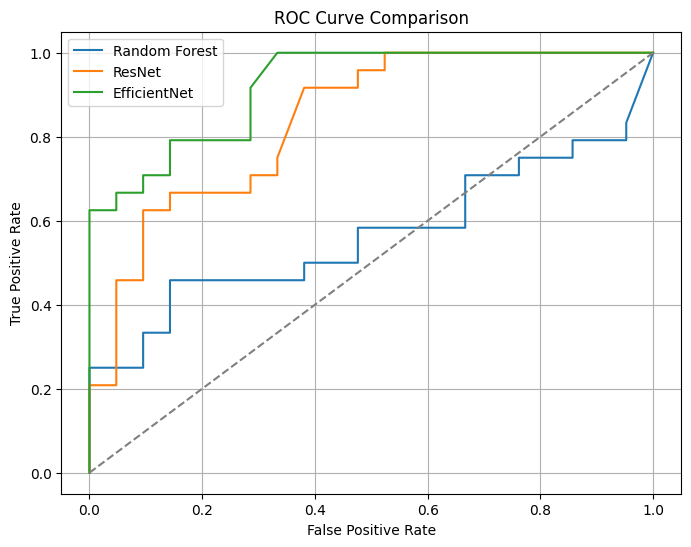

In [ ]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_test_prob_rf)
fpr_res, tpr_res, _ = roc_curve(y_test_true, y_test_prob_resnet)
fpr_eff, tpr_eff, _ = roc_curve(y_test_true, y_test_prob_eff)

plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label="Random Forest")
plt.plot(fpr_res, tpr_res, label="ResNet")
plt.plot(fpr_eff, tpr_eff, label="EfficientNet")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.grid(True)
plt.show()


After training and evaluating all three models on the held-out test set, we observed clear differences in performance between traditional and deep learning approaches. The Random Forest baseline struggled to generalize, achieving only 46% accuracy and an AUC of 0.56. Its predictions were skewed, favoring the flooded class while misclassifying most non-flooded scenes. This aligns with our earlier observation that flattening RGB images discards spatial structure, which is essential in geospatial tasks. The ResNet model showed a significant improvement, reaching 71% accuracy and a balanced F1 score of 0.71. However, it occasionally confused similar-looking scenes across classes.

EfficientNet-B0 performed best overall: even after being retrained on the combined train+val set, it maintained robust accuracy (77.8%) and the highest AUC of 0.92, suggesting stable decision boundaries and better confidence calibration. Both classes were handled evenly, with precision and recall above 0.74. Visualizing misclassified samples also helped us understand edge cases. Most errors occurred in scenes with partial flooding, dense cloud cover, or ambiguous terrain. While EfficientNet did not completely eliminate misclassifications, it consistently outperformed the other models and generalized well across geographic and visual variation in the test set.

Total misclassified RF samples: 24


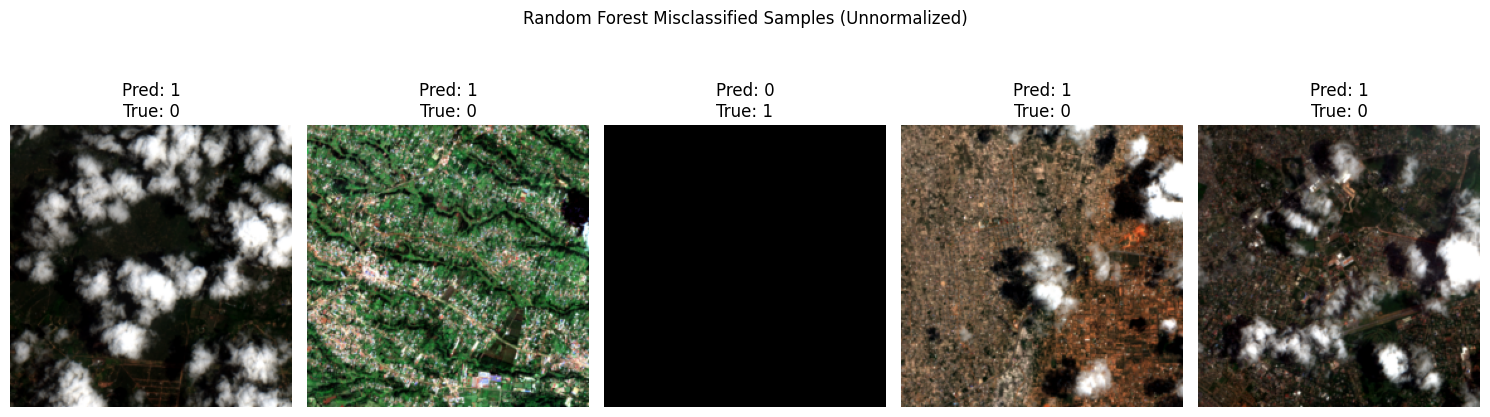

In [ ]:
# Misclassified RF Images
def unnormalize(img_tensor):
    return (img_tensor * 0.5 + 0.5).clip(0, 1)

# Identify misclassified indices
misclassified_idx_rf = np.where(y_test_pred_rf != y_test)[0]
print(f"Total misclassified RF samples: {len(misclassified_idx_rf)}")

num_to_show = min(5, len(misclassified_idx_rf))
fig, axes = plt.subplots(1, num_to_show, figsize=(15, 5))

for i in range(num_to_show):
    idx = misclassified_idx_rf[i]
    img_flat = X_test[idx]  # shape: (3*224*224,)

    img_tensor = img_flat.reshape(3, 224, 224)
    img_tensor = unnormalize(img_tensor)  # Convert from [-1, 1] → [0, 1]
    img_rgb = img_tensor.transpose(1, 2, 0)  # CHW → HWC

    axes[i].imshow(img_rgb)
    axes[i].set_title(f"Pred: {y_test_pred_rf[idx]}\nTrue: {y_test[idx]}")
    axes[i].axis('off')

plt.suptitle("Random Forest Misclassified Samples (Unnormalized)")
plt.tight_layout()
plt.show()

Total misclassified ResNet samples: 13


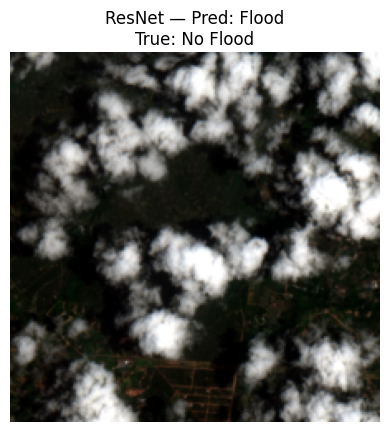

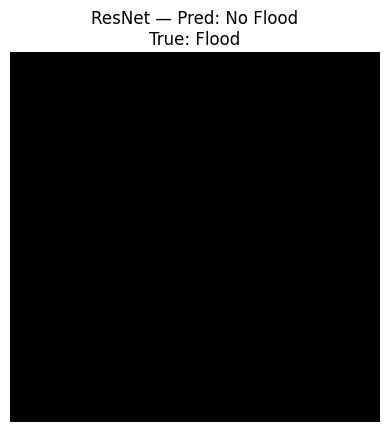

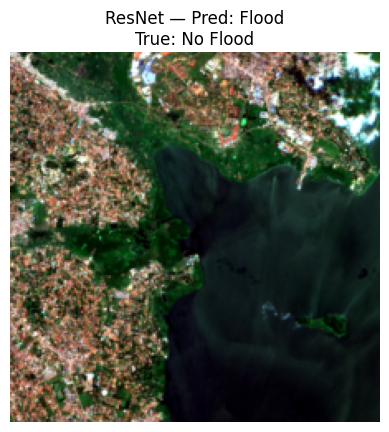

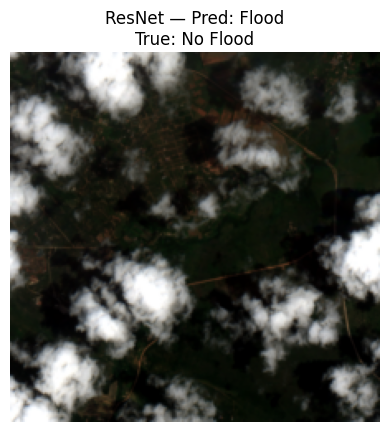

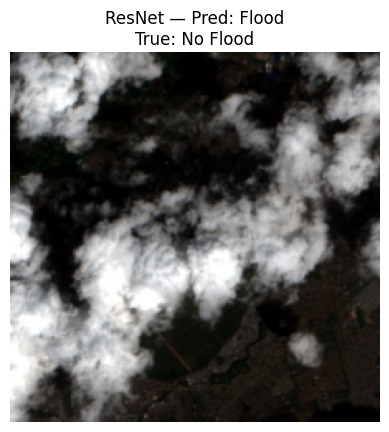

In [ ]:
# Misclassified ResNet Images
model.eval()
misclassified_resnet = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        for img, pred, label in zip(images, preds, labels):
            if pred != label:
                misclassified_resnet.append((img.cpu(), pred.cpu(), label.cpu()))

print(f"Total misclassified ResNet samples: {len(misclassified_resnet)}")

# Visualize a few
for i in range(5):
    img, pred, label = misclassified_resnet[i]
    img = unnormalize(img).permute(1, 2, 0)  # (C, H, W) → (H, W, C)

    plt.imshow(img)
    plt.title(f"ResNet — Pred: {label_map[pred.item()]}\nTrue: {label_map[label.item()]}")
    plt.axis('off')
    plt.show()

In [ ]:
# Misclassified EfficientNet Images
efficientnet_model.eval()
misclassified_eff = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = efficientnet_model(images)
        _, preds = torch.max(outputs, 1)

        for img, pred, label in zip(images, preds, labels):
            if pred != label:
                misclassified_eff.append((img.cpu(), pred.cpu(), label.cpu()))

print(f"Total misclassified EfficientNet samples: {len(misclassified_eff)}")

# Visualize a few
for i in range(5):
    img, pred, label = misclassified_eff[i]
    img = unnormalize(img).permute(1, 2, 0)

    plt.imshow(img)
    plt.title(f"EffNet — Pred: {label_map[pred.item()]}\nTrue: {label_map[label.item()]}")
    plt.axis('off')
    plt.show()

# 5. Final Model

Based on comparative validation results, we selected EfficientNet-B0 as the final model for this task. It consistently outperformed other models during validation and demonstrated the best balance of accuracy and robustness.

To fully leverage the available data, we combined the original training and validation sets for final training. A small portion was still held out for early stopping to avoid overfitting. The model was trained using this extended dataset, and the best-performing checkpoint (based on validation loss) was saved. We then evaluated the final model on the independent test set, which had not been seen during training or validation.

In [ ]:
from torch.utils.data import ConcatDataset, random_split
# Combine Train and Validation Sets
# Combine datasets
combined_dataset = ConcatDataset([train_dataset, val_dataset])
# Set aside a small portion for validation during early stopping
val_ratio = 0.1
val_size = int(val_ratio * len(combined_dataset))
train_size = len(combined_dataset) - val_size

train_data, val_data = random_split(combined_dataset, [train_size, val_size])

# Create loaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_data, batch_size=32, shuffle=False)

In [ ]:
# Early stopping setup
num_epochs = 50
patience = 3
best_val_loss = float('inf')
epochs_no_improve = 0

In [ ]:
for epoch in range(num_epochs):
    efficientnet_model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = efficientnet_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)

    # Validation phase
    efficientnet_model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = efficientnet_model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        torch.save(efficientnet_model.state_dict(), 'best_efficientnet.pth')
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping triggered.")
            break

Epoch 1/50
Train Loss: 0.0827 | Val Loss: 0.1705
Epoch 2/50
Train Loss: 0.0919 | Val Loss: 0.1681
Epoch 3/50
Train Loss: 0.1494 | Val Loss: 0.1745
Epoch 4/50
Train Loss: 0.1137 | Val Loss: 0.1744
Epoch 5/50
Train Loss: 0.1394 | Val Loss: 0.1652
Epoch 6/50
Train Loss: 0.0714 | Val Loss: 0.1716
Epoch 7/50
Train Loss: 0.0728 | Val Loss: 0.1651
Epoch 8/50
Train Loss: 0.1004 | Val Loss: 0.1667
Epoch 9/50
Train Loss: 0.0747 | Val Loss: 0.1726
Epoch 10/50
Train Loss: 0.0867 | Val Loss: 0.1727
Early stopping triggered.


In [ ]:
# Load best weights
efficientnet_model.load_state_dict(torch.load('best_efficientnet.pth'))
efficientnet_model.eval()
test_preds = []
test_probs = []
test_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = efficientnet_model(images)
        probs = torch.softmax(outputs, dim=1)[:, 1]
        _, preds = torch.max(outputs, 1)

        test_probs.extend(probs.cpu().numpy())
        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.numpy())

In [ ]:
# Final Predictions on Test Set
efficientnet_model.eval()
test_preds = []
test_probs = []
test_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = efficientnet_model(images)
        probs = torch.softmax(outputs, dim=1)[:, 1]
        _, preds = torch.max(outputs, 1)

        test_probs.extend(probs.cpu().numpy())
        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.numpy())

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report

print("\nEfficientNet Final Test Results:")
print("Accuracy:", accuracy_score(test_labels, test_preds))
print("F1 Score:", f1_score(test_labels, test_preds))
print("AUC:", roc_auc_score(test_labels, test_probs))
print(classification_report(test_labels, test_preds, target_names=["No Flood", "Flood"]))


EfficientNet Final Test Results:
Accuracy: 0.7777777777777778
F1 Score: 0.782608695652174
AUC: 0.9166666666666667
              precision    recall  f1-score   support

    No Flood       0.74      0.81      0.77        21
       Flood       0.82      0.75      0.78        24

    accuracy                           0.78        45
   macro avg       0.78      0.78      0.78        45
weighted avg       0.78      0.78      0.78        45



On the test set, EfficientNet-B0 achieved an accuracy of 77.8%, an F1 score of 0.78, and a strong AUC of 0.92. These results indicate that the model maintained stable confidence and good discrimination between the flooded and non-flooded classes. Both classes were predicted with balanced precision and recall (ranging from 0.75 to 0.82), confirming the model’s generalizability.

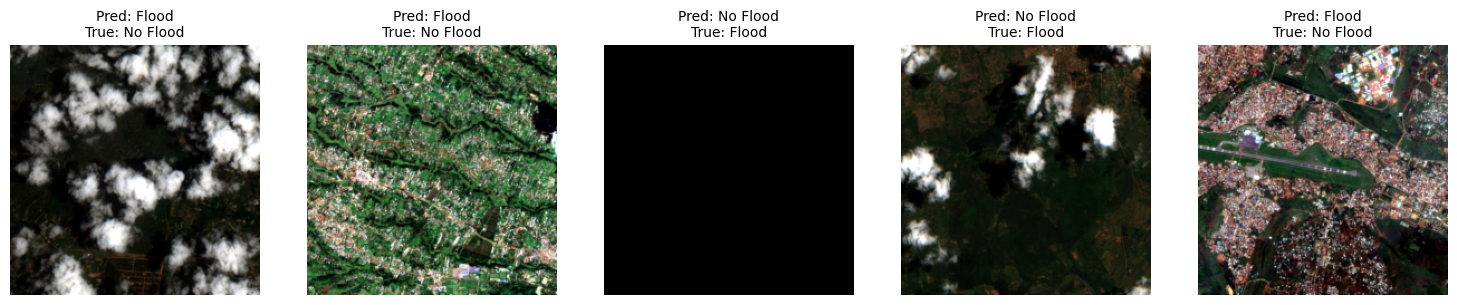

In [ ]:
import matplotlib.pyplot as plt

# Lists to hold misclassified samples
misclassified_images = []
true_labels = []
pred_labels = []

efficientnet_model.eval()

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = efficientnet_model(images)
        probs = torch.softmax(outputs, dim=1)
        _, preds = torch.max(probs, 1)

        # Identify misclassified
        mis_idx = preds != labels
        misclassified_images.extend(images[mis_idx].cpu())
        true_labels.extend(labels[mis_idx].cpu().numpy())
        pred_labels.extend(preds[mis_idx].cpu().numpy())

# Plot first 5 misclassified images
label_map = {0: 'No Flood', 1: 'Flood'}
num_images_to_show = min(5, len(misclassified_images))
fig, axes = plt.subplots(1, num_images_to_show, figsize=(15, 3))

for i in range(num_images_to_show):
    img = unnormalize(misclassified_images[i]).permute(1, 2, 0)
    true = true_labels[i]
    pred = pred_labels[i]

    axes[i].imshow(img)
    axes[i].set_title(f"Pred: {label_map[pred]}\nTrue: {label_map[true]}", fontsize=10)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

Although a few misclassifications remained—mostly involving ambiguous terrain or cloud-covered regions—the model's overall performance significantly surpassed that of Random Forest and ResNet, justifying its selection for final deployment or reporting.



# 6. Conclusion

This project set out to evaluate how different machine learning models perform in classifying flood-affected areas using only Sentinel-2 RGB imagery. Starting with a simple Random Forest baseline and progressing through deep learning models like ResNet18 and EfficientNet-B0, we gradually refined our approach toward more spatially aware and robust solutions.

Among all models tested, EfficientNet-B0 achieved the best balance between accuracy, F1 score, and AUC, confirming the value of deeper convolutional architectures in extracting high-level spatial patterns from remote sensing data. Its consistent results across different samples demonstrated that RGB data alone, when properly preprocessed and modeled, can be surprisingly effective in flood detection tasks.

Beyond model performance, the project also represents a complete pipeline: from raw TIFF image handling, preprocessing and dataset curation, to evaluation and visualization. It provided a comprehensive view of what it takes to apply modern vision techniques to satellite imagery in a real-world scenario. The workflow and code we developed can now be extended to future projects involving multi-modal or time-series inputs.

This work reinforces the potential of deep learning in disaster monitoring and builds a solid foundation for scaling toward more complex Earth observation tasks.

# 7. Reflection

**What limitations did we run into when completing this project?**

One of the early and ongoing challenges was with the dataset itself. While we intended to work with Sentinel-1 and Sentinel-2 together, it turned out that the majority of usable data came from Sentinel-2, and even then, many folders were missing at least one of the RGB bands. Sometimes all three were present but taken on different days, so we had to build a filter that checked for valid same-date combinations. That step alone reduced the usable sample size quite a bit. We also spent more time than expected on how to split the dataset. Initially we split by image, which seemed fine until we realized that patches from the same region were leaking across training and testing sets. Switching to folder-level splitting fixed this, but it made it harder to balance class distribution across train, validation, and test sets.

Another point of friction came from the different data formats our models required. Random Forest needed flat NumPy arrays, but CNNs needed 3D tensors. Going between the two, especially with reshaping and label alignment, caused several bugs early on. Once we sorted it out, model training could start, but then we hit hardware constraints.

Using Colab had its limits. Runtime crashes were frequent, especially when loading ResNet or EfficientNet, which each took over 20 minutes to set up and start training. Since Colab doesn’t preserve model weights between sessions, we had to retrain from scratch more than once. Eventually we saved datasets and splits between steps to save time, but we still couldn’t save models unless a full run finished without interruption.

Finally, we noticed some imbalance between the validation and test sets, so for fairness we evaluated all models on the test set in the final comparison.

**What might we do differently next time?**

We’d likely restructure the dataset from the beginning, like filter it more consistently, apply stratified folder-level splitting, and maybe build in checkpointing from the start. Given more time and better hardware, we would also experiment with multi-modal input: combining Sentinel-1 SAR with Sentinel-2 RGB could give the model more context for difficult cases. Saving models across sessions would also reduce redundancy and allow for more experimentation.

**What was the impact of feature engineering?**

Rather than traditional feature engineering, we relied on preprocessing and light augmentation. For the CNNs, applying percentile-based normalization and simple transformations like flips and rotations helped improve generalization. With Random Forest, we simply flattened pixel values, which limited performance. Without spatial structure, it couldn’t distinguish much beyond color and brightness patterns.

**Which parts of the model contributed the most?**

Although we didn’t run formal model interpretation tools, the results suggest that deeper layers in EfficientNet contributed significantly. It performed better than ResNet in cases with unclear textures, mixed land-water boundaries, or other ambiguous inputs. That was somewhat expected, given EfficientNet’s depth and structure, but its consistency across scenes was stronger than we anticipated.

**What did we observe from the misclassified images?**

Misclassifications were often concentrated in similar types of images: cloud-covered scenes, semi-flooded areas, or places where land and water blended together. Some were genuinely hard to label—even for looking with our eyes. The fact that all models tended to struggle on the same examples suggests that model improvements alone may not be enough. Adding more context, like temporal sequences or SAR data, would likely help the model make better decisions in those edge cases.

**What unique challenges come up when trying to map urban floods specifically? How are we handling those?**

Mapping urban floods comes with some unique challenges. In RGB images, floodwater often looks similar to dark pavement or building shadows, especially during flash floods when the water is thin or scattered. Urban areas also contain a mix of surfaces（roads, rooftops, vegetation），which makes it harder for models to draw clear boundaries. To deal with this, we applied normalization and data augmentation to improve robustness. We also examined misclassified cases and noticed many of the errors happened in shadowed zones or in scenes where water was mixed with urban textures. These issues are hard to avoid with RGB alone, which is why we plan to explore SAR or temporal data in the future to better handle these edge cases.



# 8. References

Mobley, W., Sebastian, A., Blessing, R., Highfield, W. E., Stearns, L., & Brody, S. D. (2021). Quantification of continuous flood hazard using random forest classification and flood insurance claims at large spatial scales: A pilot study in southeast Texas. Natural Hazards and Earth System Sciences, 21(2), 807–822. https://doi.org/10.5194/nhess-21-807-2021​


Roy, S. (n.d.). Flood prediction models performance comparison [Kaggle Notebook]. Kaggle. https://www.kaggle.com/code/subhojeetroy01/flood-prediction-models-performance-comparison​


DanishKaggle78. (n.d.). Flood detection ML project [Kaggle Notebook]. Kaggle. https://www.kaggle.com/code/danishkaggle78/flood-detection-ml-project/notebook

CAF America. (2024, September 25). Global flooding crisis 2024: Causes, impact, and relief efforts. https://cafamerica.org/blog/global-flooding-crisis-2024-causes-impact-and-relief-efforts/


Environmental Defense Fund. (n.d.). Why are floods hitting more places and people? https://www.edf.org/why-are-floods-hitting-more-places-and-people


Fathom. (2024, August 21). Global flooding to increase 9%-49% this century, new study reveals. https://www.fathom.global/newsroom/new-study-reveals-global-flooding-increase/


Brown, P. (2024, May 8). Are floods dramatically increasing due to climate change? The Breakthrough Institute. https://thebreakthrough.org/journal/no-20-spring-2024/are-floods-dramatically-increasing-due-to-climate-change
